<a href="https://colab.research.google.com/github/Tasfia48/Predictive_Policing/blob/master/Implication_on_Chicago_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [34]:
df =pd.read_csv('/content/drive/MyDrive/CPD/Data2019Beat.csv')
df111= df[df.BEAT==111].reset_index(drop=True)
df1= df[df.BEAT<200].reset_index(drop=True)
df1= df1[df1.BEAT>0].reset_index(drop=True)
df1.to_csv('2019District1Records.csv',index=False)
df18= df[df.BEAT>1800].reset_index(drop=True)
df18 = df18[df18.BEAT<1900].reset_index(drop=True)
df18.head()

,DATE,BEAT,WEEK,TOT_POP,WHITE,HISP,BLACK,ASIAN,OTHER,Minority_race_prac,NormalizedCount,Violent,Arrest,Stop,NormViolent,NormArrest,NormStop,policeCount
0,2019-01-01,1811,1,12319.561581,0.790311,0.065663,0.047349,0.068720,0.027957,0.209689,0.024352,1.0,0.0,0.0,0.008117,0.0000,0.0,3.0
1,2019-01-01,1812,1,7925.985683,0.790312,0.065662,0.047349,0.068720,0.027957,0.209688,0.037850,3.0,0.0,0.0,0.037850,0.0000,0.0,3.0
2,2019-01-01,1813,1,8008.883397,0.790312,0.065662,0.047349,0.068720,0.027957,0.209688,0.037458,1.0,0.0,0.0,0.012486,0.0000,0.0,3.0
3,2019-01-01,1814,1,13186.255650,0.789977,0.065636,0.047539,0.068912,0.027936,0.210023,0.022751,2.0,0.0,0.0,0.015167,0.0000,0.0,3.0
4,2019-01-01,1821,1,9900.833184,0.714421,0.059678,0.090547,0.112292,0.023061,0.285579,0.040401,2.0,1.0,0.0,0.020200,0.0101,0.0,4.0


In [35]:
col = ['DATE', 'BEAT', 'Minority_race_prac', 'policeCount', 'Arrest']
dfOne = df1[col].copy()
dfOne["DATE"]= pd.to_datetime(dfOne["DATE"]).dt.strftime('%Y-%m-%d')
dates = dfOne['DATE'].unique()

In [36]:
beat=[]
date=[]
minority =[]
normArrest=[]
normalizedCount=[]

all_beats = dfOne['BEAT'].unique()
all_keys = dfOne['DATE'].unique()
# all_districts = df['District'].unique()
for b in all_beats:
  for k in dates:
    if not ((dfOne.BEAT == b) & (dfOne.DATE == k)).any():
      m=dfOne[dfOne.BEAT == b].Minority_race_prac.mean()
      print(b,k,m)
      beat.append(b)
      date.append(k)
      minority.append(m)
      normArrest.append(0)
      normalizedCount.append(0)
      

113 2019-12-13 0.3800445930880714
114 2019-10-26 0.3801233269085581
121 2019-01-06 0.5845198601164457
121 2019-02-05 0.5845198601164457
121 2019-02-22 0.5845198601164457
121 2019-12-01 0.5845198601164457
122 2019-02-17 0.38004422922722386
122 2019-08-08 0.38004422922722386
124 2019-05-04 0.5845210295174463
124 2019-12-15 0.5845210295174463
131 2019-07-17 0.5477098597341339
131 2019-12-18 0.5477098597341339
131 2019-12-26 0.5477098597341339
132 2019-02-04 0.5299307383353684
132 2019-02-08 0.5299307383353684
132 2019-02-14 0.5299307383353684
132 2019-02-16 0.5299307383353684
132 2019-04-27 0.5299307383353684
132 2019-05-18 0.5299307383353684
132 2019-09-19 0.5299307383353684
132 2019-12-12 0.5299307383353684
132 2019-12-19 0.5299307383353684


In [37]:
temp = pd.DataFrame(columns=['DATE', 'BEAT', 'Minority_race_prac', 'policeCount', 'Arrest'])

In [38]:
temp.BEAT= beat
temp.DATE= date
temp.Minority_race_prac=minority
temp.policeCount=normArrest
temp.Arrest=normalizedCount

In [39]:
temp.head()

,DATE,BEAT,Minority_race_prac,policeCount,Arrest
0,2019-12-13,113,0.380045,0,0
1,2019-10-26,114,0.380123,0,0
2,2019-01-06,121,0.584520,0,0
3,2019-02-05,121,0.584520,0,0
4,2019-02-22,121,0.584520,0,0


In [40]:
final = dfOne.append(temp, ignore_index=True)

### Calculate C

In [41]:
newDf= final.copy()
newDf['bias_term'] = [1]*len(newDf)

In [42]:
# pd.Series([error.values()]).mean()
# a = list(error.values())
# sum(a)/len(a)

In [43]:
# initial_coef = {"vr":[0.2,-0.3],"sr":[0.2,0.3,0.4],"ar":[0.2,0.3,0.4]} # (gama, alpha, beta)
#Original values
# alpha =0.3, beta =0.4, gamma = 0.2, c1=0.8, c2=0.2
# calculated_C1.append(c1)
      # calculated_C.append(c)
      # calculated_alpha.append(alpha)
      # calculated_beta.append(beta)

total_beats = newDf.BEAT.unique().tolist()
sample_per_beat = 365

d = {}
for i in total_beats:
    d[i] = []

#hyper-parameters
# annealing = 0.01
eta = 0.1 #Learning rate



for ind in range(1,sample_per_beat+1):
  print("*****")
  print(ind," samples")
  rows = []
  for i in total_beats:
    rows.append(newDf[newDf.BEAT == i].head(ind).values)
  rows = np.array(rows)
  rows = rows.reshape((rows.shape[0]*rows.shape[1],rows.shape[2]))
  # print(rows.shape)

  train_df = pd.DataFrame(rows,columns=newDf.columns)

  c={}
  error={}
  for i in total_beats:
    c[i]= 0.1 
    error[i]= 0
  
  #initial Values
  alpha = 0.1
  beta = 0.1
  gama = 0.1
  bias = 1

  for epoch in range(100):
      
      a = train_df['Arrest']
      p = train_df['policeCount']
      m = train_df['Minority_race_prac']
      b = train_df['bias_term']

      for i in total_beats:
        error[i] = (bias*b[train_df.BEAT == i]+ a[train_df.BEAT == i] - ( 1+ alpha*p[train_df.BEAT == i]+beta * m[train_df.BEAT == i]+ c[i] )).mean()

      err = list(error.values())
      err = sum(err)/len(err)

      if epoch% 10 == 0:
        print(epoch,err,c[total_beats[0]])
      
      if err**2 < 0.001:
        break

      # eta *= (1 - annealing)
      
      alpha = alpha +  eta * (err* p).mean()
      beta = beta +  eta * (err* m).mean()
      bias = bias +  eta * err
      # gama = gama +  eta * (err*c).mean()
      for i in total_beats:
        c[i] = c[i] + eta * error[i]
  
  for i in total_beats:
    if (c[i]<0):
      c[i]=0
    elif (c[i]>1):
      c[i]=1 
    d[i].append(c[i])

  
  print("####",c[total_beats[0]])


print("**********")
# print("alpha: %f, beta: %f, gamma: %f" % (alpha,beta,gama))
# print(epoch)
print(d)

*****
1  samples
0 0.10605793750800806 0.1
#### 0.34619960314868126
*****
2  samples
0 -0.007578426128355595 0.1
#### 0.1
*****
3  samples
0 0.11817914962922016 0.1
#### 0.3095329364820146
*****
4  samples
0 0.21060339205346265 0.1
#### 0.29369960314868127
*****
5  samples
0 0.17878521023528077 0.1
#### 0.2641996031486813
*****
6  samples
0 0.23333066478073536 0.1
#### 0.38048930402639375
*****
7  samples
0 0.22813585958593016 0.1
#### 0.4042078066379482
*****
8  samples
0 0.20492157387164447 0.1
#### 0.3800074527184737
*****
9  samples
0 0.18484581629588687 0.1
#### 0.3821783424374187
*****
10  samples
0 0.17787611932618985 0.1
#### 0.23719960314868124
*****
11  samples
0 0.17547942511131387 0.1
#### 0.39632174074598225
*****
12  samples
0 0.146967028417099 0.1
#### 0.25536626981534793
*****
13  samples
0 0.15011388156395217 0.1
#### 0.2477380646871428
*****
14  samples
0 0.15086313231320297 0.1
#### 0.24048531743439555
*****
15  samples
0 0.1660579375080081 0.1
#### 0.235532936482014

(0.0, 1.0)

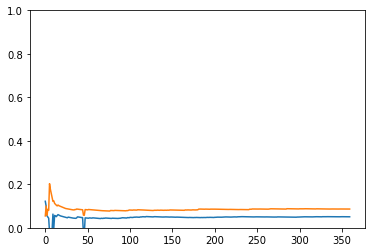

In [16]:
plt.plot(d[133])
plt.plot(d[132])
plt.ylim(0,1)
# plt.plot(d[113])
# d.keys()

(0.0, 1.0)

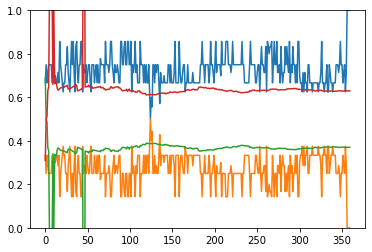

In [19]:
# plt.plot()
b1 = 133
b2 = 132
p1 = newDf[newDf.BEAT == b1]['policeCount'].values.tolist()[:360]
p2 = newDf[newDf.BEAT == b2]['policeCount'].values.tolist()[:360]
a = []
b = []
c1 = []
c2 = []
for i in range(len(p1)):
  a.append(p1[i]/(p1[i]+p2[i]))
  b.append(p2[i]/(p1[i]+p2[i]))
  c1.append(d[b1][i]/(d[b1][i]+d[b2][i]))
  c2.append(d[b2][i]/(d[b1][i]+d[b2][i]))

plt.plot(a)
plt.plot(b)
plt.plot(c1)
plt.plot(c2)
plt.ylim(0,1)
# plt.plot(p2)

In [ ]:
len(p1)

360

In [ ]:
# df18.to_csv('2019District18Records.csv',index=False)

In [21]:
# df18WithC= pd.read_csv('/content/2019District18withcriminality.csv')
# df1WithC= pd.read_csv('/content/2019District1withcriminality.csv')

In [22]:
# def plotPvsC(df,beat):
#   beat1824 = df[df.BEAT==beat].reset_index(drop=True)
#   beat1824.policeCount = (beat1824.policeCount- beat1824.policeCount.min())/ (beat1824.policeCount.max()-beat1824.policeCount.min())
#   # plt.plot(beat1824.u)
#   rolling_mean_pol = beat1824.policeCount.rolling(window=7).mean()
#   rolling_mean_crim = beat1824.u.rolling(window=7).mean()
#   plt.figure(figsize=(8,6))
#   plt.plot(rolling_mean_pol,label='Policing')
#   plt.plot(rolling_mean_crim,label='Criminality')
#   plt.ylim(0,1)
#   plt.xlabel("Time",fontsize=16)
#   plt.ylabel("Rate",fontsize=16)
#   plt.legend(fontsize='x-large')
#   plt.xticks(fontsize=14)
#   plt.yticks(fontsize=14)
#   string = str(beat)
#   plt.savefig(string+".pdf")

In [23]:
# plotPvsC(df18WithC,1824)

In [24]:
# plotPvsC(df1WithC,132)

In [25]:
# plotPvsC(df1WithC,111)

In [26]:
# plotPvsC(df18WithC,1821)

In [27]:
# plotPvsC(df1WithC,122)

In [28]:
# plotPvsC(df1WithC,133)

In [29]:
# plotPvsC(df1WithC,121)

In [30]:
# plotPvsC(df1WithC,122)

In [31]:
# plotPvsC(df1WithC,132)

In [ ]:

# df18CP= df18WithC[['DATE','BEAT','WEEK','policeCount','u']]
# beat1824 = df18CP[df18CP.BEAT==1824].reset_index(drop=True)
# beat1824.policeCount = (beat1824.policeCount- beat1824.policeCount.min())/ (beat1824.policeCount.max()-beat1824.policeCount.min())
# # plt.plot(beat1824.u)
# rolling_mean_pol = beat1824.policeCount.rolling(window=7).mean()
# rolling_mean_crim = beat1824.u.rolling(window=7).mean()
# plt.plot(rolling_mean_pol)
# plt.plot(rolling_mean_crim)
# plt.ylim(0,1)

In [ ]:

# df1CP= df1WithC[['DATE','BEAT','WEEK','policeCount','u']]
# beat1824 = df1CP[df1CP.BEAT==111].reset_index(drop=True)
# beat1824.policeCount = (beat1824.policeCount- beat1824.policeCount.min())/ (beat1824.policeCount.max()-beat1824.policeCount.min())
# # plt.plot(beat1824.u)
# rolling_mean_pol = beat1824.policeCount.rolling(window=7).mean()
# rolling_mean_crim = beat1824.u.rolling(window=7).mean()
# plt.plot(rolling_mean_pol,label='Policing')
# plt.plot(rolling_mean_crim,label='Criminality')
# plt.ylim(0,1)
# plt.xlabel("Time")

# plt.legend()

In [ ]:
# df18WithC= pd.read_csv('/content/2019District18withcriminality.csv')
# df18CP= df18WithC[['DATE','BEAT','WEEK','policeCount','u']]
# beat1824 = df18CP[df18CP.BEAT==1811].reset_index(drop=True)
# beat1824.policeCount = (beat1824.policeCount- beat1824.policeCount.min())/ (beat1824.policeCount.max()-beat1824.policeCount.min())
# # plt.plot(beat1824.u)
# rolling_mean_pol = beat1824.policeCount.rolling(window=7).mean()
# rolling_mean_crim = beat1824.u.rolling(window=7).mean()
# plt.plot(rolling_mean_pol,label='Policing')
# plt.plot(rolling_mean_crim,label='Criminality')
# plt.ylim(0,1)
# plt.xlabel("Time")

# plt.legend()

(0.0, 1.0)

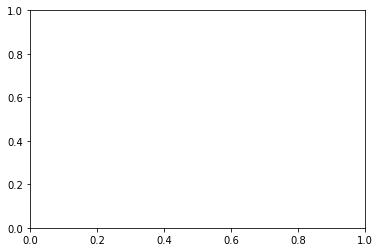

In [ ]:

plt.ylim(0,1)


In [ ]:
df18CP[df18CP.BEAT==1824]

,DATE,BEAT,WEEK,policeCount,u
7,2019-01-01,1824,1,3,0.301643
19,2019-01-02,1824,1,3,0.558361
31,2019-01-03,1824,1,3,0.357252
43,2019-01-04,1824,1,3,0.697043
55,2019-01-05,1824,1,3,0.503345
...,...,...,...,...,...
4328,2019-12-27,1824,52,3,0.297462
4340,2019-12-28,1824,52,3,0.343523
4352,2019-12-29,1824,52,3,0.524401
4364,2019-12-30,1824,1,3,0.438557
